# Testing

In [1]:
import sys, os
import torch
sys.path.append("../../")
sys.path.append("../../../")
sys.path.append("../../../../")

from sklearn.metrics import classification_report
from Clust.clust.transformation.type.DFToNPArray import transDFtoNP, trans_df_to_np, trans_df_to_np_inf
from Clust.clust.ML.tool import data as ml_data
from Clust.clust.ML.tool import scaler as ml_scaler
from Clust.clust.ML.tool import clean as ml_clean
from Clust.clust.ML.common import ML_pipeline, tool

from Clust.setting import influx_setting_KETI as ins
from Clust.clust.ingestion.influx import influx_client_v2 as influx_Client
from Clust.clust.ingestion.mongo.mongo_client import MongoClient

db_client = influx_Client.InfluxClient(ins.CLUSTDataServer2)
mongo_client = MongoClient(ins.CLUSTMetaInfo2)

#import main_regression as mr
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


## Test Data Preparation

In [2]:
app_name= "actionPattern" # "Hs2SwineFarmWithWeatherTime", "energy"
model_method = 'LSTM_cf'
model_clean = False
step = 'test'
bucket_name = 'integration'
data_clean_level=0

In [3]:
model_name = None
model_name = tool.get_default_model_name(model_name, app_name, model_method, model_clean)
collection_name = 'meta'
db_name = 'model'
model_meta_list= mongo_client.get_document_by_json(db_name, collection_name, {'modelName': model_name})
model_meta = model_meta_list[0] ## ??

In [4]:
model_meta

{'trainDataInfo': {'bucket_name': 'integration',
  'collection_name': 'classification_actionPattern',
  'ms_name': 'classification_actionPattern_cleanLevel0_trainX',
  'ingestion_type': 'multiple_ms_by_time',
  'ingestion_param': {'ms_list_info': [['bio_action_sensors',
     'accelerationTrain']],
   'start_time': '1992-01-11',
   'end_time': '2012-02-27'},
  'processing_type': 'step_3',
  'process_param': {'refine_param': {'removeDuplication': {'flag': False},
    'staticFrequency': {'flag': False, 'frequency': None}},
   'outlier_param': {'certainErrorToNaN': {'flag': False},
    'unCertainErrorToNaN': {'flag': False}},
   'imputation_param': {'flag': False}},
  'integration_param': {'integration_frequency': 675,
   'param': {},
   'method': 'meta',
   'integration_duration': 'common'},
  'clean_level': 0},
 'modelName': 'actionPattern_LSTM_cf_False',
 'dataSplitMode': 'windows_split',
 'featureXList': ['col_0',
  'col_1',
  'col_2',
  'col_3',
  'col_4',
  'col_5',
  'col_6',
  'col

### 1-2. Data Ingestion
#### 1-2-1. X-y Data Ingestion pipeline

In [5]:
model_purpose = model_meta['modelPurpose']
dataset_name = model_purpose + '_' + app_name  
scaler_param= model_meta['scalerParam']
data_name_X = dataset_name + '_cleanLevel' + str(data_clean_level)+'_'+step+'X'
data_name_y = dataset_name+'_cleanLevel' + str(data_clean_level)+'_'+ step+'y'
data_y_flag = model_meta['data_y_flag']

In [6]:
feature_X_list = model_meta['featureXList']
feature_y_list = model_meta["featureyList"]
model_file_path = model_meta['files']['modelFile']["filePath"]

In [7]:
# Data Ingestion
ingestion_method = 'ms_all'
ingestion_param_X = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_X,
    'feature_list' : feature_X_list                              
}
ingestion_param_y = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_y,
    'feature_list' : feature_y_list                              
}

In [8]:
data_X, data_y = ML_pipeline.Xy_data_preparation(ingestion_param_X, data_y_flag, ingestion_param_y, ingestion_method, db_client)

In [9]:
print(data_X.shape, data_y.shape)

(177280, 9) (1385, 1)


In [10]:
X_scaler_file_path = model_meta['files']['XScalerFile']["filePath"]
y_scaler_file_path = model_meta['files']['yScalerFile']["filePath"]
y_scaler_file_path

'./scaler/classification_actionPattern_cleanLevel0_trainy/minmax/f69156750a210491ffd4a67b605bc88b/scaler.pkl'

In [11]:
scaler_param = model_meta["scalerParam"]
test_X, scaler_X , test_y, scaler_y  = ML_pipeline.Xy_data_scaling_test(data_X, data_y, X_scaler_file_path, y_scaler_file_path, scaler_param)

In [12]:
split_mode = model_meta['dataSplitMode']
transformParameter = model_meta["transformParameter"]
test_X_array, test_y_array = ML_pipeline.transform_data_by_split_mode(split_mode, transformParameter, test_X, test_y)

window_size: 128 nan_limit_num: 64
(177280, 9) (1385, 128, 9)
(1385, 1) (1385, 1)


In [13]:
transformParameter

{'past_step': 128, 'max_nan_limit_ratio': 0.5}

In [44]:
modelParameter = model_meta["modelParameter"]

testParameter = {
    'device': device,
    'batch_size': 1
}

In [45]:
testParameter

{'device': 'cpu', 'batch_size': 1}

In [46]:
from Clust.clust.ML.classification.test import ClassificationTest as CT
def clust_classification_test(test_X_array, test_y_array, testParameter, model_method, model_file_path, modelParameter):
    ct = CT()
    ct.set_param(testParameter)
    ct.set_model(model_method, model_file_path, modelParameter)
    ct.set_data(test_X_array, test_y_array)
    preds, probs, trues, acc = ct.test()
    
    return preds, probs, trues, acc

In [47]:
preds, probs, trues, acc = clust_classification_test(test_X_array, test_y_array, testParameter, model_method, model_file_path, modelParameter)


Start testing data

** Performance of test dataset ==> PROB = [[9.8866987e-01 1.1057919e-02 6.6231725e-05 4.6855093e-05 1.0828351e-04
  5.0728770e-05]
 [9.8868412e-01 1.1045526e-02 6.5767912e-05 4.6542191e-05 1.0764598e-04
  5.0425526e-05]
 [9.8865044e-01 1.1078733e-02 6.5838845e-05 4.6629597e-05 1.0781101e-04
  5.0489536e-05]
 ...
 [5.2000437e-02 9.4366360e-01 9.3603641e-04 1.6057915e-03 9.6843648e-04
  8.2557433e-04]
 [9.8877615e-01 1.0953938e-02 6.5772780e-05 4.6448436e-05 1.0743825e-04
  5.0352850e-05]
 [9.8856932e-01 1.1157221e-02 6.6410423e-05 4.7134952e-05 1.0887357e-04
  5.0936269e-05]], ACC = 0.9805054151624548
** Dimension of result for test dataset = (1385,)


In [48]:
print(test_X_array.shape, test_y_array.shape)
print(preds.shape, trues.shape)

(1385, 128, 9) (1385, 1)
(1385,) (1385,)


In [49]:
target = feature_y_list[0]
scaler, feature_list = ML_pipeline.get_scaler_information_by_y_flag(data_y_flag, scaler_X, scaler_y, feature_X_list, feature_y_list)

In [50]:
target

'value'

In [51]:
feature_list

['value']

In [52]:
scaler

MinMaxScaler()

In [53]:
result_metrics = classification_report(trues, preds, output_dict = True)

In [54]:
df_result = ml_data.get_prediction_df_result(preds, trues, scaler_param, scaler, feature_list, target)

scale


In [55]:
result_metrics = classification_report(trues, preds, output_dict = True)
df_result = ml_data.get_prediction_df_result(preds, trues, scaler_param, scaler_y, feature_list= feature_y_list, target_col = target)

scale


{0.0, 5.0}

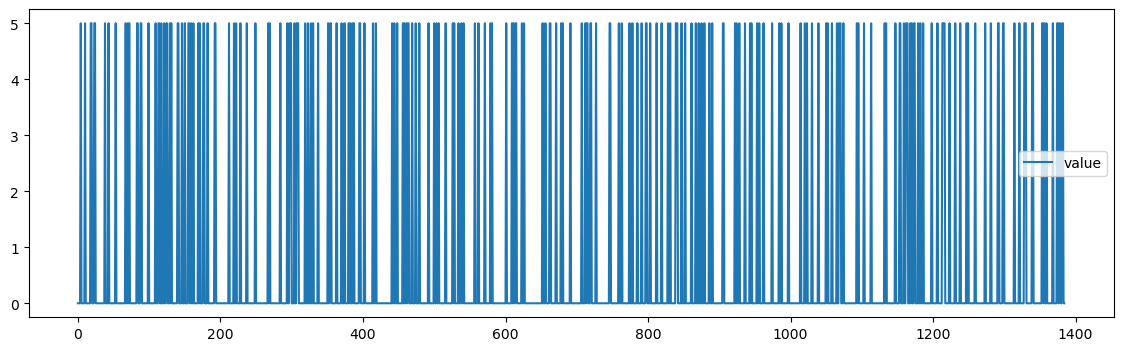

In [56]:
df_result[['value']].plot()
set(df_result['prediction'].values)

In [57]:
df_result

,value,prediction
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,5.0,0.0
...,...,...
1380,0.0,0.0
1381,5.0,5.0
1382,5.0,5.0
1383,0.0,0.0


In [58]:
result_metrics

{'0': {'precision': 0.9770212765957447,
  'recall': 1.0,
  'f1-score': 0.9883770985794231,
  'support': 1148},
 '1': {'precision': 1.0,
  'recall': 0.8860759493670886,
  'f1-score': 0.9395973154362416,
  'support': 237},
 'accuracy': 0.9805054151624548,
 'macro avg': {'precision': 0.9885106382978723,
  'recall': 0.9430379746835442,
  'f1-score': 0.9639872070078324,
  'support': 1385},
 'weighted avg': {'precision': 0.9809533758353176,
  'recall': 0.9805054151624548,
  'f1-score': 0.9800299443520338,
  'support': 1385}}

## Testing

In [6]:
feature_list = model_meta["featureList"]
target = model_meta["target"]
model_method = model_meta["model_method"]
scaler_param = model_meta["scalerParam"]
model_file_path = model_meta['files']['modelFile']["filePath"]

X_scaler_file_path = model_meta['files']['XScalerFile']["filePath"]
y_scaler_file_path = model_meta['files']['yScalerFile']["filePath"]


dim = None
if model_method == "FC_cf":
    dim = 2

test_X, scaler_X = ml_scaler.get_scaled_test_data(dataX[feature_list], X_scaler_file_path, scaler_param)
test_y, scaler_y = ml_scaler.get_scaled_test_data(datay[target], y_scaler_file_path, scaler_param)# No Scale

test_X, test_y = trans_df_to_np(test_X, test_y, window_num, dim)

In [7]:
modelParameter = model_meta["modelParameter"]

testParameter = {
    'device': device,
    'batch_size': 1,
    'window_num' : window_num
}

In [8]:
from Clust.clust.ML.classification.test import ClassificationTest as CT

ct = CT()
ct.set_param(testParameter)
ct.set_model(model_method, model_file_path, modelParameter)
ct.set_data(test_X, test_y)
preds, probs, trues, acc = ct.test()

/programdrive/anaconda3/envs/clust/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



Start testing data

** Performance of test dataset ==> PROB = [[0.27221224 0.14693156 0.20503466 0.03351972 0.3411454  0.00115647]
 [0.25972977 0.1287405  0.20829622 0.04112133 0.3608106  0.00130157]
 [0.23107077 0.43879282 0.19649522 0.00971253 0.12218859 0.00174   ]
 ...
 [0.27264982 0.1513896  0.2022552  0.03240357 0.3402574  0.00104439]
 [0.18764034 0.06324291 0.14058961 0.22844113 0.37672803 0.00335801]
 [0.2860485  0.17173684 0.20145312 0.03245208 0.30693388 0.0013756 ]], ACC = 0.4382671480144404
** Dimension of result for test dataset = (1385,)


In [9]:
print(test_X.shape, test_y.shape)
print(preds.shape, probs.shape)

(1385, 9, 128) (1385,)
(1385,) (1385, 6)


In [10]:
result_metrics = classification_report(trues, preds, output_dict = True)
df_result = ml_data.get_prediction_df_result(preds, trues, scaler_param, scaler_y, feature_list= target, target_col = target[0])

noscale


/programdrive/anaconda3/envs/clust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/programdrive/anaconda3/envs/clust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/programdrive/anaconda3/envs/clust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

{0, 1, 3, 4, 5}

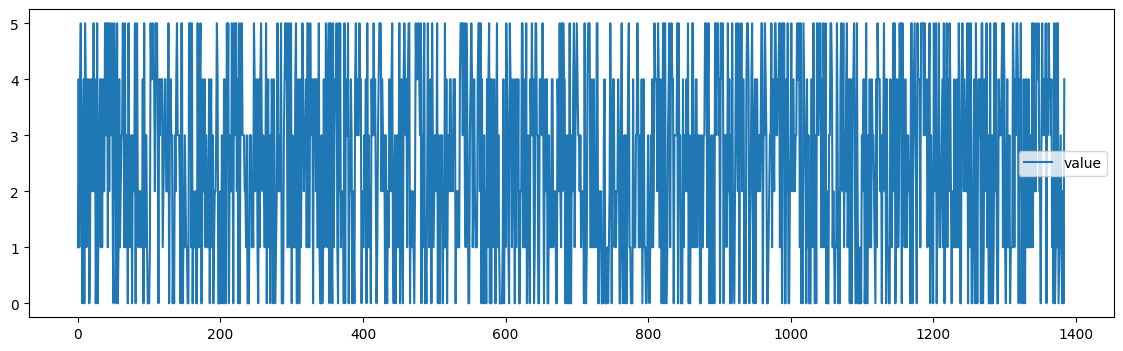

In [11]:
df_result[['value']].plot()
set(df_result['prediction'].values)

In [14]:
df_result

,value,prediction
0,1,4
1,4,4
2,1,1
3,4,4
4,5,3
...,...,...
1380,1,1
1381,0,1
1382,2,4
1383,0,4


In [12]:
result_metrics

{'0': {'precision': 0.3007518796992481,
  'recall': 0.1593625498007968,
  'f1-score': 0.20833333333333334,
  'support': 251},
 '1': {'precision': 0.36904761904761907,
  'recall': 0.4170403587443946,
  'f1-score': 0.3915789473684211,
  'support': 223},
 '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 197},
 '3': {'precision': 0.5035971223021583,
  'recall': 0.6140350877192983,
  'f1-score': 0.5533596837944663,
  'support': 228},
 '4': {'precision': 0.26515151515151514,
  'recall': 0.5622489959839357,
  'f1-score': 0.36036036036036034,
  'support': 249},
 '5': {'precision': 1.0,
  'recall': 0.8185654008438819,
  'f1-score': 0.9002320185614849,
  'support': 237},
 'accuracy': 0.43826714801444044,
 'macro avg': {'precision': 0.40642468936675674,
  'recall': 0.4285420655153846,
  'f1-score': 0.402310723903011,
  'support': 1385},
 'weighted avg': {'precision': 0.41561675957382643,
  'recall': 0.43826714801444044,
  'f1-score': 0.4107324895045231,
  'support': 1385}}

In [13]:
acc

0.4382671480144404